# <a id="prep"></a>**1. DATA PRE-PROCESSING**
 First, the data will be loaded and cleaned into a usuable format for analysis. Specifically, I'll need to address:  
 - [missing data](#missing)
 - [outliers](#outliers)  
 - [data types](#types)
 - [feature engineering](#engineering)


In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.mlab as mlab
import pandas as pd
import seaborn as sns
import sklearn
import warnings
warnings.filterwarnings("ignore")

# Settings
import matplotlib
matplotlib.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (8.5, 5)
plt.rcParams["patch.force_edgecolor"] = True
pd.set_option('display.float_format', lambda x: '%.3f' % x)
sns.mpl.rc("figure", figsize=(8.5,5))

# Read data
train_data = pd.read_csv('nyc_taxi_trip_duration.csv')

# View data
train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.954,40.779,-73.964,40.771,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988,40.732,-73.995,40.695,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997,40.721,-73.948,40.775,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.962,40.760,-73.957,40.781,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017,40.708,-73.988,40.741,N,848


## <a id="missing"></a> Data Pre-Processing: Missing Data 
After loading the data, I'll examine its struture to identify any missing observations that will need to be addressed.

In [2]:
# Data Shape
print('Data Shape',train_data.shape)
train_data.info()

Data Shape (729322, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  object 
 10  trip_duration       729322 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 61.2+ MB


Based on the entry totals above, there are no missing observations  to be imputed. <br/>
 
## <a id="outliers"></a> Data Pre-Processing: Outliers
Next, I will look at a statistical summary of the data to identify any obvious outliers.

In [3]:
# Statistical summary
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vendor_id,729322.000,1.535,0.499,1.000,1.000,2.000,2.000,2.000
passenger_count,729322.000,1.662,1.312,0.000,1.000,1.000,2.000,9.000
pickup_longitude,729322.000,-73.974,0.070,-121.933,-73.992,-73.982,-73.967,-65.897
pickup_latitude,729322.000,40.751,0.034,34.712,40.737,40.754,40.768,51.881
dropoff_longitude,729322.000,-73.973,0.070,-121.933,-73.991,-73.980,-73.963,-65.897
dropoff_latitude,729322.000,40.752,0.036,32.181,40.736,40.755,40.770,43.921
trip_duration,729322.000,952.229,3864.626,1.000,397.000,663.000,1075.000,1939736.000


**passenger_count**  
The `passenger_count` variable has a minimum value of 0 passengers, which does not make sense in the context of this business case.  These observations are most likely errors and will need to removed from the dataset.    

Another red flag is that `passenger_count` has a maximum value of 9 passengers -  highly unlikely for an NYC taxicab.   According to the NYC Taxi & Limousine Commission, the maximum number of people allowed in a yellow taxicab, by law, is five passengers (in a five passenger taxicab).  There are exceptions for passengers under the age of 7 who may sit on an adult's lap. However, it is unlikely that a full 5 person taxi cab would have that many children under the age of 7 on board to yield a passenger count as high as 9.   This observation is likely an error and will also to be removed from the dataset.   

**Longitude and Latitude Coordinates**  
Based on different coordinate estimates of New York City, the latitude and longitude ranges are as follows:  
- Latitude is between 40.7128 and 40.748817
- Longitude is between  - 74.0059 and  - 73.968285 

The statisical summary of pick-up and drop-off coordinates show max and min observations that fall outside of the NYC city coordinate range.  I will exclude these data points as this analysis is  limited to New York City proper.

**trip_duration**  
Lastly, there are unusual observations present in our target variable, `trip_duration`.  A max trip_duration of 3526282.00 sec (~ 980 hours) is not a  realistic trip time - a clear indication that outliers are present in the data.  A systematic way to remove these outliers is to exclude all data points that are a specified number of standard deviations away from the mean.  In this case, I will remove `trip_duration` observations that are more than two standard deviations away from the mean duration time, 959.492 sec (~15.99 min).

In [4]:
# Remove passenger_count outliers
train_data = train_data[train_data['passenger_count']>0]
train_data = train_data[train_data['passenger_count']<9]

# Remove coordinate outliers
train_data = train_data[train_data['pickup_longitude'] <= -73.75]
train_data = train_data[train_data['pickup_longitude'] >= -74.03]
train_data = train_data[train_data['pickup_latitude'] <= 40.85]
train_data = train_data[train_data['pickup_latitude'] >= 40.63]
train_data = train_data[train_data['dropoff_longitude'] <= -73.75]
train_data = train_data[train_data['dropoff_longitude'] >= -74.03]
train_data = train_data[train_data['dropoff_latitude'] <= 40.85]
train_data = train_data[train_data['dropoff_latitude'] >= 40.63]

# Remove trip_duration outliers
trip_duration_mean = np.mean(train_data['trip_duration'])
trip_duration_std = np.std(train_data['trip_duration'])
train_data = train_data[train_data['trip_duration']<=trip_duration_mean + 2*trip_duration_std]
train_data = train_data[train_data['trip_duration']>= trip_duration_mean - 2*trip_duration_std]

# Confirm removal
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
vendor_id,718612.000,1.535,0.499,1.000,1.000,2.000,2.000,2.000
passenger_count,718612.000,1.662,1.312,1.000,1.000,1.000,2.000,6.000
pickup_longitude,718612.000,-73.974,0.037,-74.030,-73.992,-73.982,-73.968,-73.751
pickup_latitude,718612.000,40.751,0.027,40.630,40.737,40.754,40.768,40.850
dropoff_longitude,718612.000,-73.974,0.033,-74.030,-73.991,-73.980,-73.964,-73.750
dropoff_latitude,718612.000,40.752,0.030,40.630,40.736,40.755,40.769,40.850
trip_duration,718612.000,824.091,641.348,1.000,394.000,655.000,1056.000,8588.000


## <a id="types"></a> **Data Pre-Processing: Data Types**  
Next, I'll do a quick review of the data types to confirm that the variables are being assigned correctly.

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 718612 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  718612 non-null  object 
 1   vendor_id           718612 non-null  int64  
 2   pickup_datetime     718612 non-null  object 
 3   dropoff_datetime    718612 non-null  object 
 4   passenger_count     718612 non-null  int64  
 5   pickup_longitude    718612 non-null  float64
 6   pickup_latitude     718612 non-null  float64
 7   dropoff_longitude   718612 non-null  float64
 8   dropoff_latitude    718612 non-null  float64
 9   store_and_fwd_flag  718612 non-null  object 
 10  trip_duration       718612 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 65.8+ MB


The pickup and dropoff timestamp variables are being treated as non-null objects.  These features should be specified as date objects to allow for easier feature engineering and analysis later on.  

In [6]:
# Convert timestamps to date objects
train_data['pickup_datetime'] = pd.to_datetime(train_data.pickup_datetime) # Pickups
train_data['dropoff_datetime'] = pd.to_datetime(train_data.dropoff_datetime) # Drop-offs

# Confirm changes
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 718612 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  718612 non-null  object        
 1   vendor_id           718612 non-null  int64         
 2   pickup_datetime     718612 non-null  datetime64[ns]
 3   dropoff_datetime    718612 non-null  datetime64[ns]
 4   passenger_count     718612 non-null  int64         
 5   pickup_longitude    718612 non-null  float64       
 6   pickup_latitude     718612 non-null  float64       
 7   dropoff_longitude   718612 non-null  float64       
 8   dropoff_latitude    718612 non-null  float64       
 9   store_and_fwd_flag  718612 non-null  object        
 10  trip_duration       718612 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 65.8+ MB


## <a id="engineering"></a> **Data Pre-Processsing: Feature Engineering**  
The `pickup_datetime` and `dropoff_datetime` variables both combine date and time observations into the same column.  I will delimit this date and time information into separate columns to allow for easier analysis downstream.    

The hour and day of week a passenger is picked up may influence trip duration so I will extract these features from the `pickup_datetime` variable also.  This is not necessary for `dropoff_datetime` because, logically, the day and hour a passenger is dropped off would have no bearing on `trip_duration` because this is information is recorded *after* the trip is completed.   

In [7]:
# Delimit pickup_datetime variable 
train_data['pickup_date'] = train_data['pickup_datetime'].dt.date # Extract date
train_data['pickup_time'] = train_data['pickup_datetime'].dt.time # Extract time

# Delimit dropoff_datetime variables
train_data['dropoff_date'] = train_data['dropoff_datetime'].dt.date # Extract date
train_data['dropoff_time'] = train_data['dropoff_datetime'].dt.time # Extract time

# Additional pickup features
train_data['pickup_month'] = train_data['pickup_datetime'].dt.month # Extract month
# train_data['pickup_month'] = train_data.pickup_datetime.dt.to_period('M') # Extract yearmonth
#train_data['pickup_YYYYMM'] = train_data['pickup_datetime'].apply(lambda x: x.strftime('%Y%m')) # Extract yearmonth
train_data['pickup_hour'] = train_data['pickup_datetime'].dt.hour # Extract hour
train_data['pickup_weekday'] = train_data['pickup_datetime'].dt.dayofweek # Extract day of week

# Drop concatentated timestamp columns
train_data.drop(['pickup_datetime'], axis = 1, inplace = True)
train_data.drop(['dropoff_datetime'], axis = 1, inplace = True)

# Confirm changes
train_data.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'pickup_time',
       'dropoff_date', 'dropoff_time', 'pickup_month', 'pickup_hour',
       'pickup_weekday'],
      dtype='object')

# <a id="eda"></a>**2.  EXPLORATORY DATA ANALYSIS**
## Target Variable: trip_duration
The target variable we are trying to predict is `trip_duration`. I'll need to examine its distribution to see if there are transformations that need to be applied.  


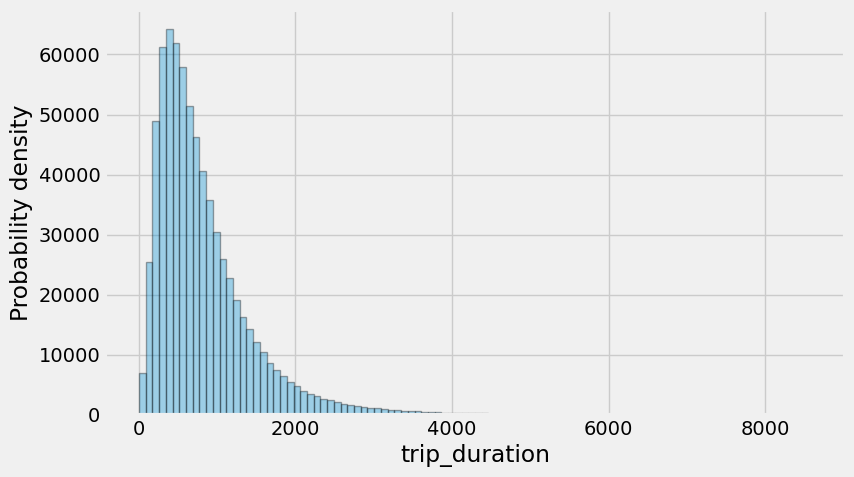

,count,mean,std,min,25%,50%,75%,max
trip_duration,718612.000,824.091,641.348,1.000,394.000,655.000,1056.000,8588.000


In [8]:
# Mean distribution
mu = train_data['trip_duration'].mean()

# Std distribution
sigma = train_data['trip_duration'].std()
num_bins = 100

# Histogram 
patches = plt.hist(train_data['trip_duration'], num_bins, density=0,
                           edgecolor = 'black', lw = 1, alpha = 0.35)
# Normal Distribution

plt.xlabel('trip_duration')
plt.ylabel('Probability density')

#fig.tight_layout()
plt.show()

# Statistical summary
train_data.describe()[['trip_duration']].transpose()

There is a clear indication that `trip_duration` is highly skewed to the right based on two key signals:  
- Skewness value > 1.0
- Long right tail

The median `trip_duration` is only 655 seconds (~11 min).  However, there are `trip_duration` observations as high as 11,411 sec (3.12 hours) that were not removed previously as they are still within two standard deviations of the mean (our specified outlier cutoff).  As a result, these high `trip_duration` observations are skewing the distribution to the right.  

Thus, applying the log transformation to `trip_duration` will normalize its distribution and reduce the influence of these high observations in the right tail.     

## **Feature Variables**
The remaining columns in our dataset are the 'feature variables'.  These are the variables that will be fed into our machine learning model to predict the dependent variable, `trip_duration`.   I will explore each one of these features to better understand the information it contains and what transformations are needed before we can proceed to the learning process.  

In [9]:
# Feature names
train_data.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag', 'trip_duration', 'pickup_date', 'pickup_time',
       'dropoff_date', 'dropoff_time', 'pickup_month', 'pickup_hour',
       'pickup_weekday'],
      dtype='object')

** Id**  
The `id` variable is a unique identifier of each trip.  I will explore how this feature varies over time (if at all).

pickup_date
2016-01-01    3500
2016-01-02    3180
2016-01-03    3093
2016-01-04    3294
2016-01-05    3535
              ... 
2016-06-26    3528
2016-06-27    3547
2016-06-28    3577
2016-06-29    3787
2016-06-30    3816
Name: id, Length: 182, dtype: int64


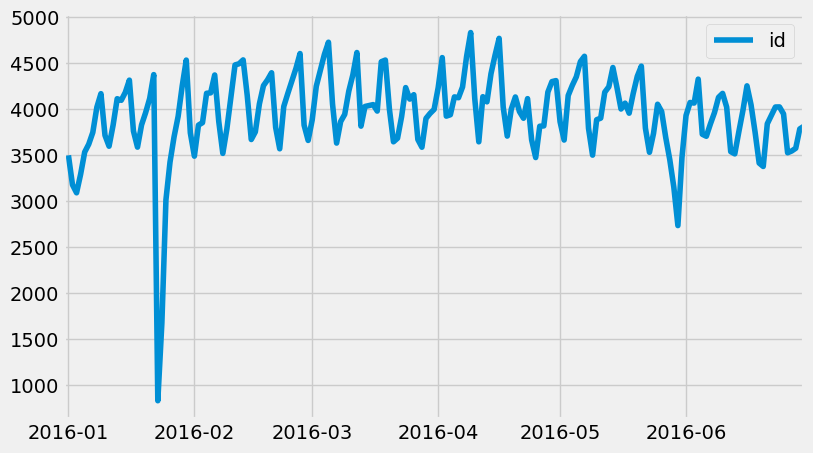

In [10]:
# Summarize total trips by day
pickups_by_day = train_data.groupby('pickup_date').count()["id"]
print(pickups_by_day)

# Create graph
pickups_graph = pickups_by_day.plot(x = 'pickup_date', y = 'id', figsize = (8.5,5),legend = True)

# # Customize tick size
# pickups_graph.tick_params(axis = 'both', which = 'major', labelsize = 12)

# # Bold horizontal line at y = 0
# pickups_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

# # Customize tick labels of the y-axis

# Add an extra vertical line by tweaking the range of the x-axis
pickups_graph.set_xlim(left = '2015-12-31', right = '2016-06-30')

# Remove the label of the x-axis
pickups_graph.xaxis.label.set_visible(False)

plt.show()

**Trip Id Over Time**  
There is a unusual drop in the total number of `id` around late January.  At first glance, it is easy to assume that this could be just seasonality.   However, the decrease is much more drastic relative to other winter days before/after the drop and looks to be isolated around a single day.  Thus, a more plausible explanation for this outlier could be order entry error or some other extraneous event.  

In [11]:
# Identify where drop occured
train_data.groupby('pickup_date').count()['id'].sort_values(ascending = True)[[0]]

pickup_date
2016-01-23    834
Name: id, dtype: int64

Upon further investigation, the drop occured on January 23, 2016 - the date of New York's first big snow storm of the year, where they were hit with 26.8 inches of snowfall.  Although there was a significant decline in the overall number of taxi rides, the median `trip_duration` of the rides that *were* given that day of 456.5 seconds does not seem to be out of the ordinary.  

Although the `id` variable provides interesting insight about trips over time, the actual Id of a trip record will not be useful in predicting `trip_duration` in our alogrithm.  Thus, I will remove this feature when it comes time to train the model.  <br/><br/>

**Vendor Id**  
The `vendor_id` variable is a code indicating the provider associated with each trip record. I will examine if there is a provider that takes longer trips relative to the others. 

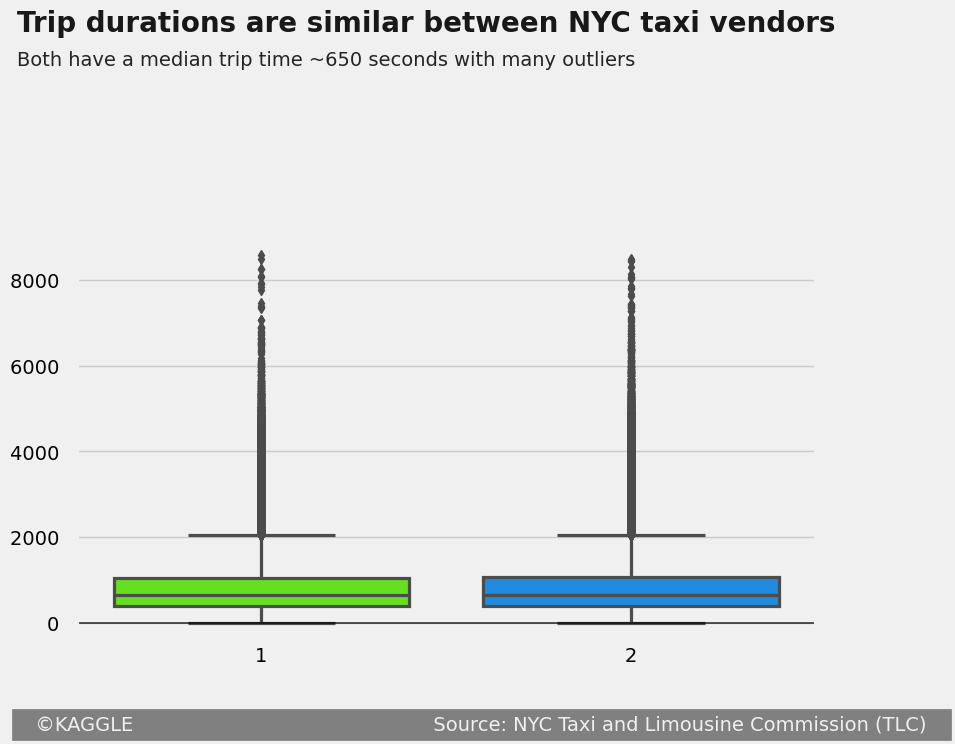

,count,mean,std,min,25%,50%,75%,max
vendor_id,,,,,,,,
1,334312.000,818.245,634.664,1.000,392.000,652.000,1051.000,8588.000
2,384300.000,829.176,647.064,1.000,396.000,658.000,1061.000,8481.000


In [12]:
# Create boxplot
plt.figure(figsize=(8.5,5))
vendor_graph = sns.boxplot(x = 'vendor_id', y = 'trip_duration', data = train_data, 
                          palette = 'gist_rainbow', linewidth = 2.3)

# Customize tick labels of the y-axis
vendor_graph.set_yticklabels(labels = [-10, '0  ', '2000  ', '4000  ', '6000  ', '8000  ', '10000  ','12000 s'])

# Bolding horizontal line at y = 0
vendor_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
vendor_graph.xaxis.label.set_visible(False)
vendor_graph.yaxis.label.set_visible(False)

# Add signature bar
vendor_graph.text(x = -.66, # Adjusts left side of signature bar
               y = -2500,  
               s = '   ©KAGGLE                                                 Source: NYC Taxi and Limousine Commission (TLC)   ', # copyright symbol ALT + 0169
              fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey') 

# # Adding a title and a subtitle
vendor_graph.text(x =-.66, y = 13800, s = "Trip durations are similar between NYC taxi vendors",
               fontsize =20 , weight = 'bold', alpha = .90)
vendor_graph.text(x = -.66, y = 13000.3, 
               s = 'Both have a median trip time ~650 seconds with many outliers',
              fontsize = 14, alpha = .85)
plt.show()

# Statistical summary
train_data.groupby('vendor_id')['trip_duration'].describe()


The median `trip_duration` is similar between the two vendors. However, it is worth nothing that each vendor also has a significant number of outliers beyond the upper fence.  That is, both have outliers that are greater than the upper quartile by at least 1.5x the interquartile range.   

**store_and_fwd_flag**  
The `store_and_fwd_flag` variable indicates whether the trip record was stored in vehicle memory before forwarding to the vendor because the vehicle did not have a direct connection to the server.  An immediate question that comes to mind is if these 'Store and Forward' trips are contributing to the `trip_duration` outliers for the two vendors noted above.  

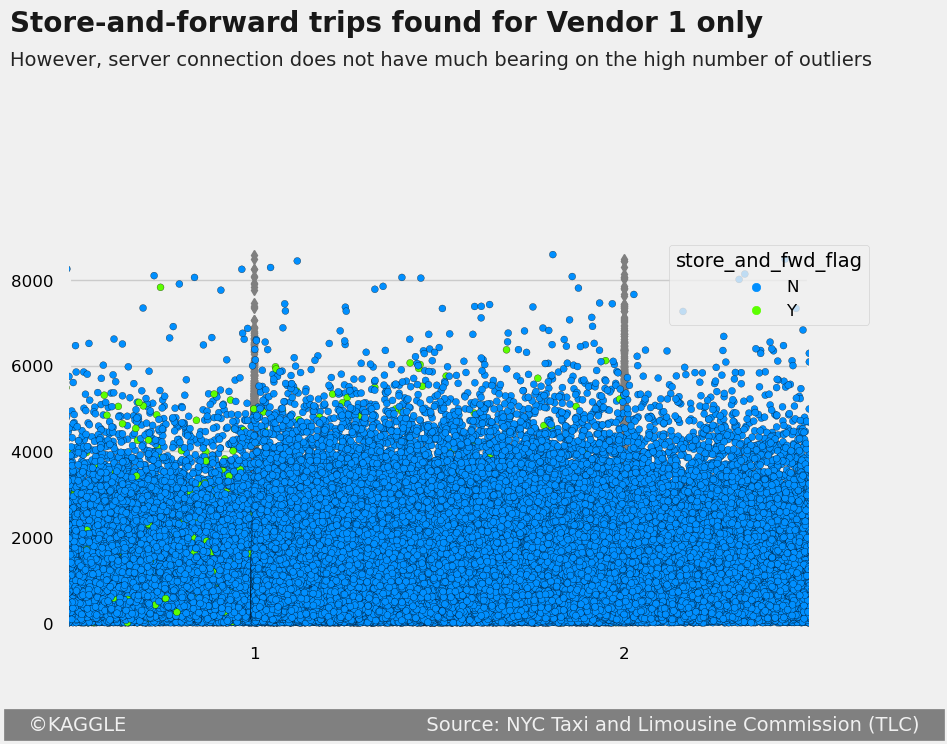

store_and_fwd_flag,N,Y
vendor_id,,
1,330362.000,3950.000
2,384300.000,0.000


In [13]:
# Create boxplot
plt.figure(figsize=(8.5,5))
vendor_graph = sns.boxplot(x = 'vendor_id', y = 'trip_duration', data = train_data, 
                          orient = 'v',color = 'lightgrey', linewidth = 2.3)
plt.setp(vendor_graph.artists, alpha = 0.5)

# Create strip plot
sns.stripplot(data = train_data, x = 'vendor_id', y = 'trip_duration', jitter = 1, size = 5,
             edgecolor = 'black', linewidth = .2,palette = 'gist_rainbow_r',hue = 'store_and_fwd_flag')

# Customize tick size
vendor_graph.tick_params(axis = 'both', which = 'major', labelsize = 12)

# Customize tick labels of the y-axis
vendor_graph.set_yticklabels(labels = [-10, '0  ', '2000  ', '4000  ', '6000  ', '8000  ', '10000  ','12000 s'])

# Bolding horizontal line at y = 0
vendor_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
vendor_graph.xaxis.label.set_visible(False)
vendor_graph.yaxis.label.set_visible(False)

# Add signature bar
vendor_graph.text(x = -.66, # Adjusts left side of signature bar
               y = -2500,  
               s = '   ©KAGGLE                                                 Source: NYC Taxi and Limousine Commission (TLC)   ', # copyright symbol ALT + 0169
              fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey') 

# Adding a title and a subtitle
vendor_graph.text(x =-.66, y = 13800, s = 'Store-and-forward trips found for Vendor 1 only',
               fontsize =20 , weight = 'bold', alpha = .90)
vendor_graph.text(x = -.66, y = 13000.3, 
               s = 'However, server connection does not have much bearing on the high number of outliers',
              fontsize = 14, alpha = .85)
# Format legend
vendor_graph.legend(title = 'store_and_fwd_flag', bbox_to_anchor = (.80,1),loc = 2, fontsize=12)
plt.show()

# Statistical summary
train_data.groupby(['vendor_id','store_and_fwd_flag'])['store_and_fwd_flag'].count().unstack().fillna(0)


Only Vendor 1 had trip records that were stored and forwarded to the vendor rather than directly onto the server.  Intially, I thought these 'Store and Forward' trips would be reponsible for most of that vendor's outliers, but these trips account for only a small portion of Vendor 1 observations.  Most of the outliers are "normal" trips that were directly stored onto the Vendor server.  Thus, this `store_and_fwd_flag`  may not be informative in predicting trip_duration times.   <br/> <br/>

**Passenger Count**  
 The `passenger_count` variable is the number of passengers in the vehicle as inputed by the driver.  The assumption is that trips with more passengers are inherently longer due to more stops, but I will explore this variable to test this assumption.

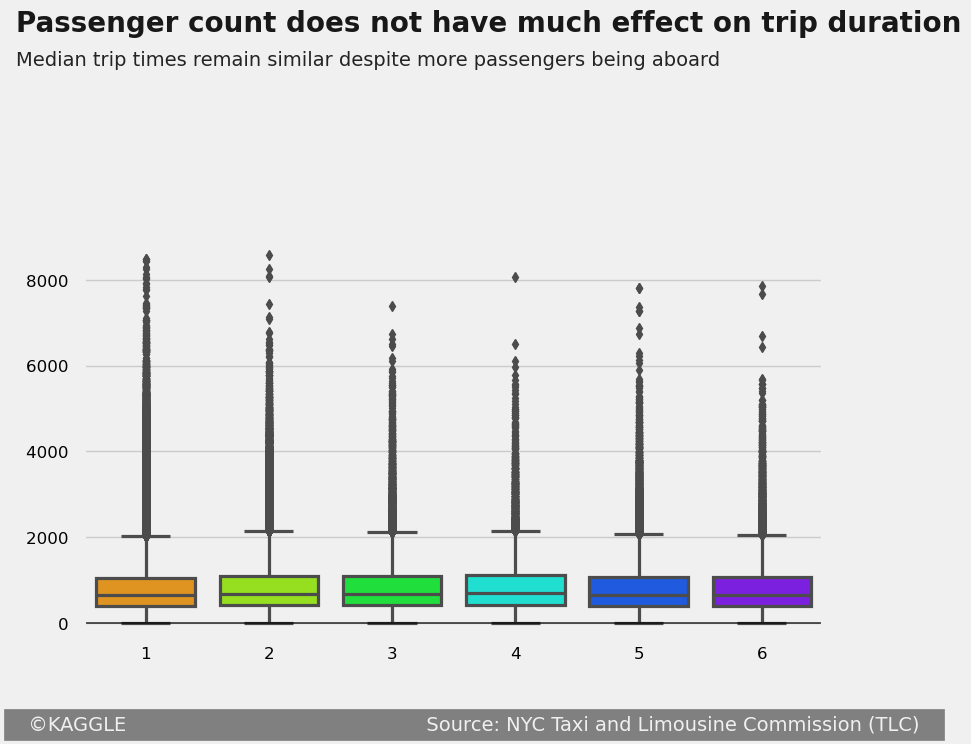

passenger_count,1,2,3,4,5,6
count,510065.000,103375.000,29232.000,13831.000,38337.000,23772.000
mean,812.354,863.501,855.039,868.644,831.487,828.624
std,630.038,679.812,659.527,675.885,647.137,647.483
min,1.000,1.000,2.000,2.000,2.000,3.000
25%,389.000,411.000,415.000,420.000,395.000,398.000
50%,648.000,681.000,677.000,694.000,660.000,654.000
75%,1044.000,1099.000,1093.000,1108.000,1066.000,1060.000
max,8496.000,8588.000,7381.000,8055.000,7814.000,7847.000


In [14]:
# Settings
import matplotlib
matplotlib.style.use('fivethirtyeight')

# Create boxplot
plt.figure(figsize=(8.5,5))
passenger_graph = sns.boxplot(x = 'passenger_count', y = 'trip_duration', data = train_data, 
                          palette = 'gist_rainbow', linewidth = 2.3)

# Customize tick size
passenger_graph.tick_params(axis = 'both', which = 'major', labelsize = 12)

# Customize tick labels of the y-axis
passenger_graph.set_yticklabels(labels = [-10, '0  ', '2000  ', '4000  ', '6000  ', '8000  ', '10000  ','12000 s'])

# Bolding horizontal line at y = 0
passenger_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Add an extra vertical line by tweaking the range of the x-axis
#month_graph.set_xlim(left = -1, right = 6)

# Remove the label of the x-axis
passenger_graph.xaxis.label.set_visible(False)
passenger_graph.yaxis.label.set_visible(False)

# Add signature bar
passenger_graph.text(x = -1.1, # Adjusts left side of signature bar
               y = -2500,  
               s = '   ©KAGGLE                                                 Source: NYC Taxi and Limousine Commission (TLC)   ', # copyright symbol ALT + 0169
              fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey') 

# Alternative signature bar
# fte_graph.text(x = 1967.1, y = -6.5,
#               s = '________________________________________________________________________________________________________________',
#               color = 'grey', alpha = .70)
# fte_graph.text(x = 1966.1, y = -9,
#               s ='   ©DATAQUEST                                                                               Source: National Center for Education Statistics   ', # copyright symbol ALT + 0169
#               fontsize = 14, color = 'grey', alpha = .7)

# # Adding a title and a subtitle
passenger_graph.text(x =-1.05, y = 13800, s = "Passenger count does not have much effect on trip duration",
               fontsize =20 , weight = 'bold', alpha = .90)
passenger_graph.text(x = -1.05, y = 13000.3, 
               s = 'Median trip times remain similar despite more passengers being aboard',
              fontsize = 14, alpha = .85)
plt.show()

# Statistical summary
train_data.groupby('passenger_count')['trip_duration'].describe().transpose()

Surpringly, the median `trip_duration` does not vary much as passenger_count increases.  Trips with just one passenger seem to have more outliers than other trips.   <br/> <br/>

**Trip Duration by Pickup Hour and Day**  
I suspect that trips are longer on the weekends due to higher traffic levels, but will need to explore if there are other times during the week `trip duration` is higher than average.  

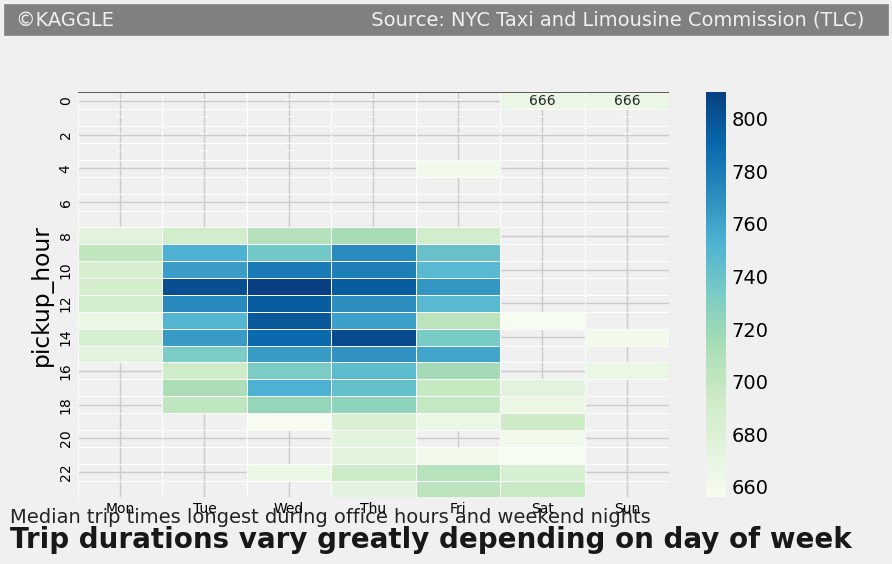

In [15]:
# Trips by Hour and Day of Week
trip_duration_median = train_data['trip_duration'].median()
plt.figure(figsize=(8.5,5))
pickup_hourday = train_data.groupby(['pickup_hour','pickup_weekday'])['trip_duration'].median().unstack()
hourday_graph = sns.heatmap(pickup_hourday[pickup_hourday>trip_duration_median],
                                   lw = .5, annot = True, cmap = 'GnBu', fmt = 'g',annot_kws = {"size":10} )
# Customize tick label size
hourday_graph.tick_params(axis = 'both', which = 'major', labelsize = 10)

# Customize tick labels of the y-axis
hourday_graph.set_xticklabels(labels = ['Mon', 'Tue', 'Wed','Thu','Fri','Sat','Sun'])

# Bolding horizontal line at y = 0
hourday_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)

# Remove the label of the x-axis
hourday_graph.xaxis.label.set_visible(False)

# Add signature bar
hourday_graph.text(x = -.8,  y = -4,
                   s = ' ©KAGGLE                                          Source: NYC Taxi and Limousine Commission (TLC)   ',
fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey') 

# # Adding a title and a subtitle
hourday_graph.text(x =-.8, y = 27, s = "Trip durations vary greatly depending on day of week",
               fontsize =20 , weight = 'bold', alpha = .90)
hourday_graph.text(x =-.8, y = 25.5, 
               s = 'Median trip times longest during office hours and weekend nights',
              fontsize = 14, alpha = .85)

# plt.ylabel('pickup_hour (military time)')
# plt.xlabel('pickup_weekday (Mon - Sun)')
# plt.title('Median Trip Duration by Pickup Hour and Day of Week')
plt.show()

Trips tend much longer than the median `trip_duration` of 655 seconds during the following parts of the week: 
- **Monday - Thursday Office Hours: ** 8:00 am  -  6:00 pm  
- **Thursday, Friday, Saturday Nights: ** 6:00 pm - midnight
- **Early Saturday & Sunday Mornings: **12:00 am  - 1:00 am  
- **Sunday Afternoons:** 2:00 pm and 4:00 pm<br/><br/>

**Trip Duration by Month**    
Next, I'll examine if `trip_duration` varies by month due to seasonality.  



In [ ]:
# Box plot of pickups by month
import matplotlib
matplotlib.style.use('fivethirtyeight')

# Create boxplot
plt.figure(figsize=(8.5,5))
month_graph = sns.boxplot(x = 'pickup_month', y = 'trip_duration', data = train_data, 
                          palette = 'gist_rainbow', linewidth = 2.3)

# Customize tick size
month_graph.tick_params(axis = 'both', which = 'major', labelsize = 12)

# Customize tick labels of the y-axis
month_graph.set_yticklabels(labels = [-10, '0  ', '2000  ', '4000  ', '6000  ', '8000  ', '10000  ','12000 s'])

# Bolding horizontal line at y = 0
month_graph.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .70)


# Add an extra vertical line by tweaking the range of the x-axis
#month_graph.set_xlim(left = -1, right = 6)

# Remove the label of the x-axis
month_graph.xaxis.label.set_visible(False)
month_graph.yaxis.label.set_visible(False)

# Add signature bar
month_graph.text(x = -1.1, # Adjusts left side of signature bar
               y = -2500,  
               s = '   ©KAGGLE                                                 Source: NYC Taxi and Limousine Commission (TLC)   ', # copyright symbol ALT + 0169
              fontsize = 14, color = '#f0f0f0', backgroundcolor = 'grey') 

# Alternative signature bar
# fte_graph.text(x = 1967.1, y = -6.5,
#               s = '________________________________________________________________________________________________________________',
#               color = 'grey', alpha = .70)
# fte_graph.text(x = 1966.1, y = -9,
#               s ='   ©DATAQUEST                                                                               Source: National Center for Education Statistics   ', # copyright symbol ALT + 0169
#               fontsize = 14, color = 'grey', alpha = .7)

# # Adding a title and a subtitle
month_graph.text(x =-1.05, y = 13800, s = "Month of transaction has minimal effect on trip duration",
               fontsize =20 , weight = 'bold', alpha = .90)
month_graph.text(x = -1.05, y = 13000.3, 
               s = 'Median trip times hover around ~650 seconds throughout the year',
              fontsize = 14, alpha = .85)
plt.show()

# Statistical summary
train_data.groupby('pickup_month')['trip_duration'].describe().transpose()

June has the highest median `trip_duration` overall, but only slightly.  Median trip times seem to hover around the 10-12 minute mark and do not vary much from month-to-month.  This may be an indication that this month feature will not be helpful in predicting our target variable, `trip_duration`.  <br/><br/>
**Plot Rides**   
Next, I will plot the pickup and drop off points of each taxi ride.  

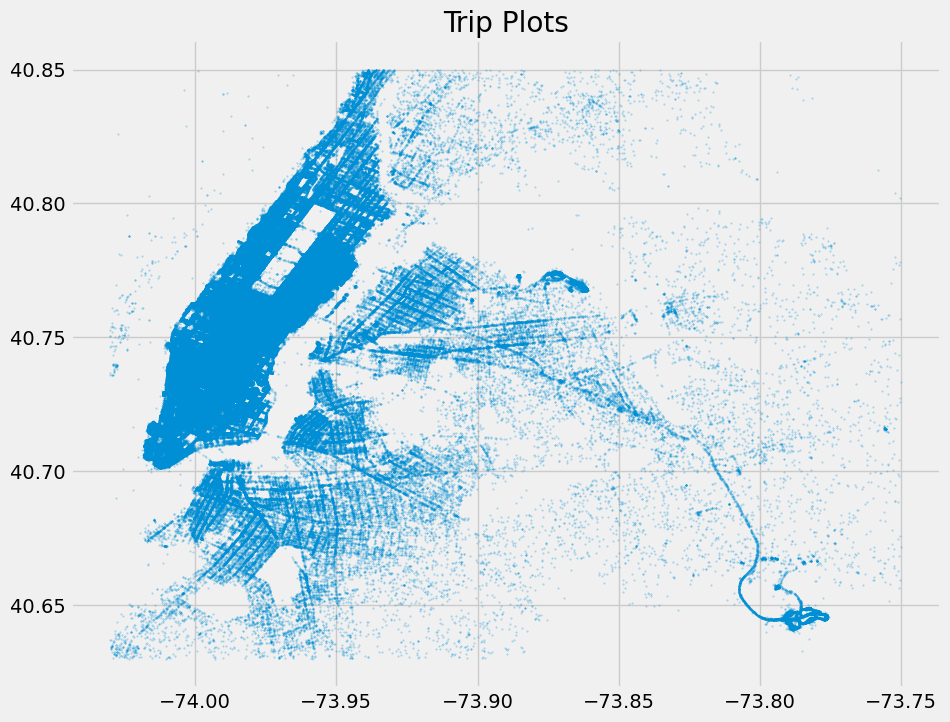

In [17]:
longitude = list(train_data.pickup_longitude) + list(train_data.dropoff_longitude)
latitude = list(train_data.pickup_latitude) + list(train_data.dropoff_latitude)
plt.figure(figsize = (10,8))
plt.plot(longitude,latitude,'.',alpha = .40, markersize = .8)
plt.title('Trip Plots')
plt.show()

**Plot by Neighborhood**  
Using the KMeans alogirthm, we can cluster the data points into the different neighborhoods of NYC.  

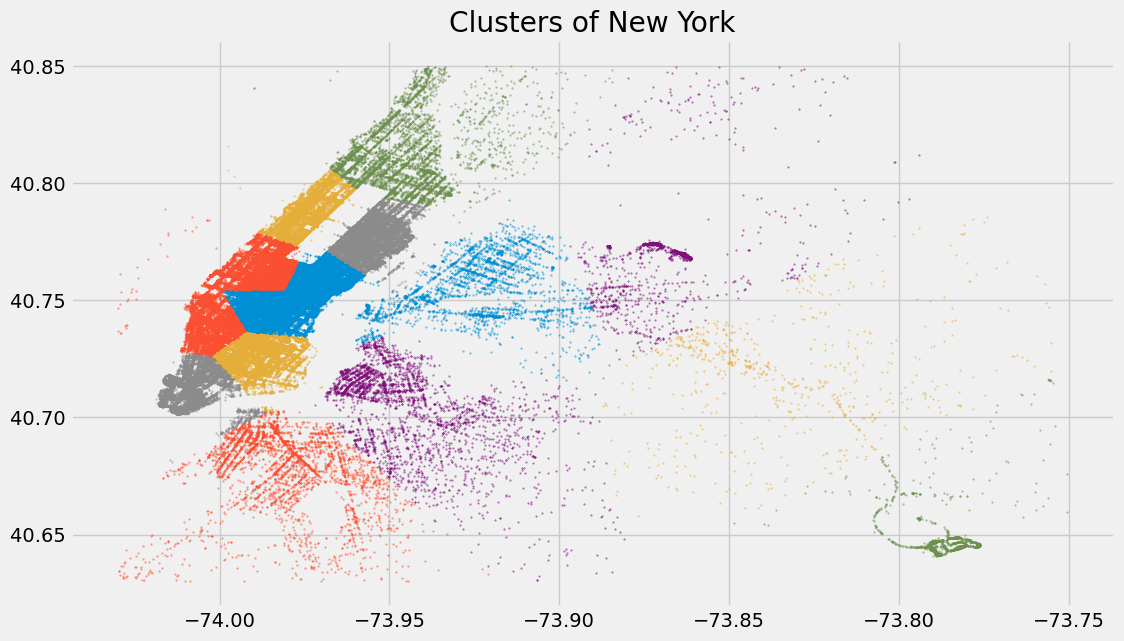

In [18]:
# Create data frame of coordinates
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

# Clusters of New York
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_
loc_df = loc_df.sample(200000)
plt.figure(figsize = (12,7))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.8, markersize = 0.8)
plt.title('Clusters of New York')
plt.show()

**Relationships Between Variables**  
Now that each feature has been explored individually, I will examine how they relate to the target variable as well as each other.  Variables that are highly correlated (correlation cofficient >.70) are likely to convey redudant information and can be removed from the dataset.  Reducing the data's dimentionality in this way will make the data easier to work with and allow for better model results.  

In [19]:
# Correlations to trip_duration
corr = train_data.select_dtypes(include = ['float64', 'int64']).iloc[:, 1:].corr()
cor_dict = corr['trip_duration'].to_dict()
del cor_dict['trip_duration']
print("List the numerical features in decending order by their correlation with trip_duration:\n")
for ele in sorted(cor_dict.items(), key = lambda x: -abs(x[1])):
    print("{0}: {1}".format(*ele))
    
# Correlation matrix heatmap
corrmat = train_data.corr()
plt.figure(figsize=(12, 7))

# Number of variables for heatmap
k = 76
cols = corrmat.nlargest(k, 'trip_duration')['trip_duration'].index
cm = np.corrcoef(train_data[cols].values.T)

# Generate mask for upper triangle
mask = np.zeros_like(cm, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1)
sns.heatmap(cm, mask=mask, cbar=True, annot=True, square=True,\
                 fmt='.2f',annot_kws={'size': 12}, yticklabels=cols.values,\
                 xticklabels=cols.values, cmap = 'coolwarm',lw = .1)
plt.show() 

List the numerical features in decending order by their correlation with trip_duration:

pickup_longitude: 0.36131758986895124
dropoff_longitude: 0.25492640477031137
pickup_latitude: -0.23494615788756026
dropoff_latitude: -0.1973630347346873
passenger_count: 0.015549046719593075


ValueError: could not convert string to float: 'id1080784'

**Correlations**  
Not suprisingly, the correlation coefficient of the coordinate features: `pickup_latitude`, `pickup_longitude`, `dropoff_latitude`, `dropoff_longitude`, indicates a linear relationship exists between them.  However, this correlation is under .50 and is not strong enough to merit removal from the data set.    

There is a weak positive correlation between the longitude variables and `trip_duration`.  There is also a weak negative correlation betwen the latitude variables and `trip_duration`.    



In [20]:
# Check for categorical variables
train_data.head()

,id,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_time,dropoff_date,dropoff_time,pickup_month,pickup_hour,pickup_weekday
0,id1080784,2,1,-73.954,40.779,-73.964,40.771,N,400,2016-02-29,16:40:21,2016-02-29,16:47:01,2,16,0
1,id0889885,1,2,-73.988,40.732,-73.995,40.695,N,1100,2016-03-11,23:35:37,2016-03-11,23:53:57,3,23,4
2,id0857912,2,2,-73.997,40.721,-73.948,40.775,N,1635,2016-02-21,17:59:33,2016-02-21,18:26:48,2,17,6
3,id3744273,2,6,-73.962,40.760,-73.957,40.781,N,1141,2016-01-05,09:44:31,2016-01-05,10:03:32,1,9,1
4,id0232939,1,1,-74.017,40.708,-73.988,40.741,N,848,2016-02-17,06:42:23,2016-02-17,06:56:31,2,6,2


In [21]:
# Encode categorical variables
train_data['store_and_fwd_flag'] = train_data['store_and_fwd_flag'].map({'N':0,'Y':1})

**Drop Unnecessary Features**  
The machine learning algorithm will not be able to accept dates and times as inputs so the following features will be removed prior to training: `pickup_date`, `pickup_time`, `dropoff_date`,  and `dropoff_time`.  Instead, this information will be represented by the `pickup_month` and `pickup_hour` features that were engineered during pre-processing.

In [22]:
# Remove unnecessary features
train_data.drop(['pickup_date','pickup_time','dropoff_date', 'dropoff_time','id'], 
                axis = 1, inplace = True)

In [23]:
train_data.columns

Index(['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'pickup_month', 'pickup_hour', 'pickup_weekday'],
      dtype='object')

Now that data is model-ready, we are finally ready for the fun part - building models! First, I will split the data into training and test sets.  Next, I will feed these sets into a number of Regression algorithms to determine which learner is the most performant to use for the Kaggle submission.  

In [24]:
# Split
# Create matrix of features
X = train_data[['vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'store_and_fwd_flag','pickup_month', 'pickup_hour',
       'pickup_weekday']] # double brackets!

# Create array of target variable 
y = train_data['trip_duration']

# Create train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)